### The Linear Regression File 

# number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
#          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import preprocess

files = preprocess.potential_files[:5]

preprocess_class_instantiation = preprocess.preprocess(files, 7)

datasets = preprocess_class_instantiation.generate_data()

file_for_given_row = {}
for index, crypto_name in enumerate(files):
    file_for_given_row[crypto_name] = index
    # if crypto_name == '1INCH.csv':
    # print(f'index : {index} -- crypto_name : {crypto_name}')

# for key, val in file_for_given_row.items():
#     print(key, val)

# print(file_for_given_row['1INCH.csv'])

# for f in files:
#     print(f"https://www.kaggle.com/datasets/svaningelgem/crypto-currencies-daily-prices?resource=download&select={f}")

# print(datasets)

processing files
Loading 1INCH.csv...
Loading AAVE.csv...
Loading ADA.csv...
Loading ALGO.csv...
Loading AMP.csv...
The columns are: (number of days since start,open,high,low,close,sma(10 days),golden cross, death cross)


In [3]:
##### NESTED LIST RETRIEVAL OF X FOR GIVEN CURRENCY ##################################################################################
# filename = '1INCH.csv'

def get_X_or_y_for_given_currency(currency, x_or_y):
        processed_file_dict = {}
        if (x_or_y == 'X') or (x_or_y == 'x'):
            x_or_y = 0
        elif (x_or_y == 'Y') or (x_or_y == 'y'):
            x_or_y = 1
        else:
            print(f'x_or_y needs to be x or y')
        row = file_for_given_row[currency]
        
        for csv_name, row in file_for_given_row.items():
            if currency == csv_name:
                processed_file_dict[csv_name] = datasets[row][x_or_y]
                return processed_file_dict[csv_name]
    
# get_X_or_y_for_given_currency(filename, 'X')
# get_X_or_y_for_given_currency(filename, 'y')

In [4]:
def the_currency(currency_we_want_to_look_at):
	

	X = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'X')
	y = get_X_or_y_for_given_currency(currency_we_want_to_look_at, 'y')

	return X, y

currency_we_want_to_look_at = '1INCH.csv'
# currency_we_want_to_look_at = 'AAVE.csv'
# currency_we_want_to_look_at = 'ADA.csv'
# currency_we_want_to_look_at = 'ALGO.csv'
# currency_we_want_to_look_at = 'AMP.csv'
X, y = the_currency(currency_we_want_to_look_at)

# print("first row of X:", X[0])
# print("first 10 closes from X[:,4]:", X[:10, 4])
# print("first 10 y values:", y[:10])


# Multivariable Linear Regression Section
### 1) find the most sig weihts (features) and dicuss what that means
### 2) get the LOBF to be fitted to the data trajectory
### 3) discuss various errors measured against the data and what that tells us about the real values vs our pred values ()

### get a function that fits the line better 

##### A model that is overfitting has the following characteristics:

###### - It matches the training set too closely.
###### - It does well on the training data, but doesn't *generalize* to new data.  In other words, it performs poorly on independent test data.
###### - It learns from the noise in the data, rather than the signal.

Figure(2000x1000)
{0: {'train': {'MAE': 0.08395077836505026, 'MSE': 0.03216879557560645, 'RMSE': 0.1793566156449392}, 'test': {'MAE': 0.08620814998643603, 'MSE': 0.03958591301996747, 'RMSE': 0.19896208940390497}, 'naive_MAE': 0.6405055236523227}, 1: {'train': {'MAE': 0.08720755801962043, 'MSE': 0.029297977967326132, 'RMSE': 0.17116652116382494}, 'test': {'MAE': 0.09062497749524921, 'MSE': 0.034880915544298514, 'RMSE': 0.1867643315633328}, 'naive_MAE': 0.6405055236523227}, 2: {'train': {'MAE': 131.70513212799548, 'MSE': 25231.918543713466, 'RMSE': 158.8455808126668}, 'test': {'MAE': 132.82276827157204, 'MSE': 24289.762363665242, 'RMSE': 155.8517319880188}, 'naive_MAE': 0.6405055236523227}, 3: {'train': {'MAE': 88509406.26037538, 'MSE': 1.2294163365275654e+16, 'RMSE': 110879048.3602545}, 'test': {'MAE': 88460680.10922468, 'MSE': 1.1523472171843758e+16, 'RMSE': 107347436.72693707}, 'naive_MAE': 0.6405055236523227}, 4: {'train': {'MAE': 297.01826468747043, 'MSE': 149532.69214793234, 'RMSE'

<Figure size 2000x1000 with 0 Axes>

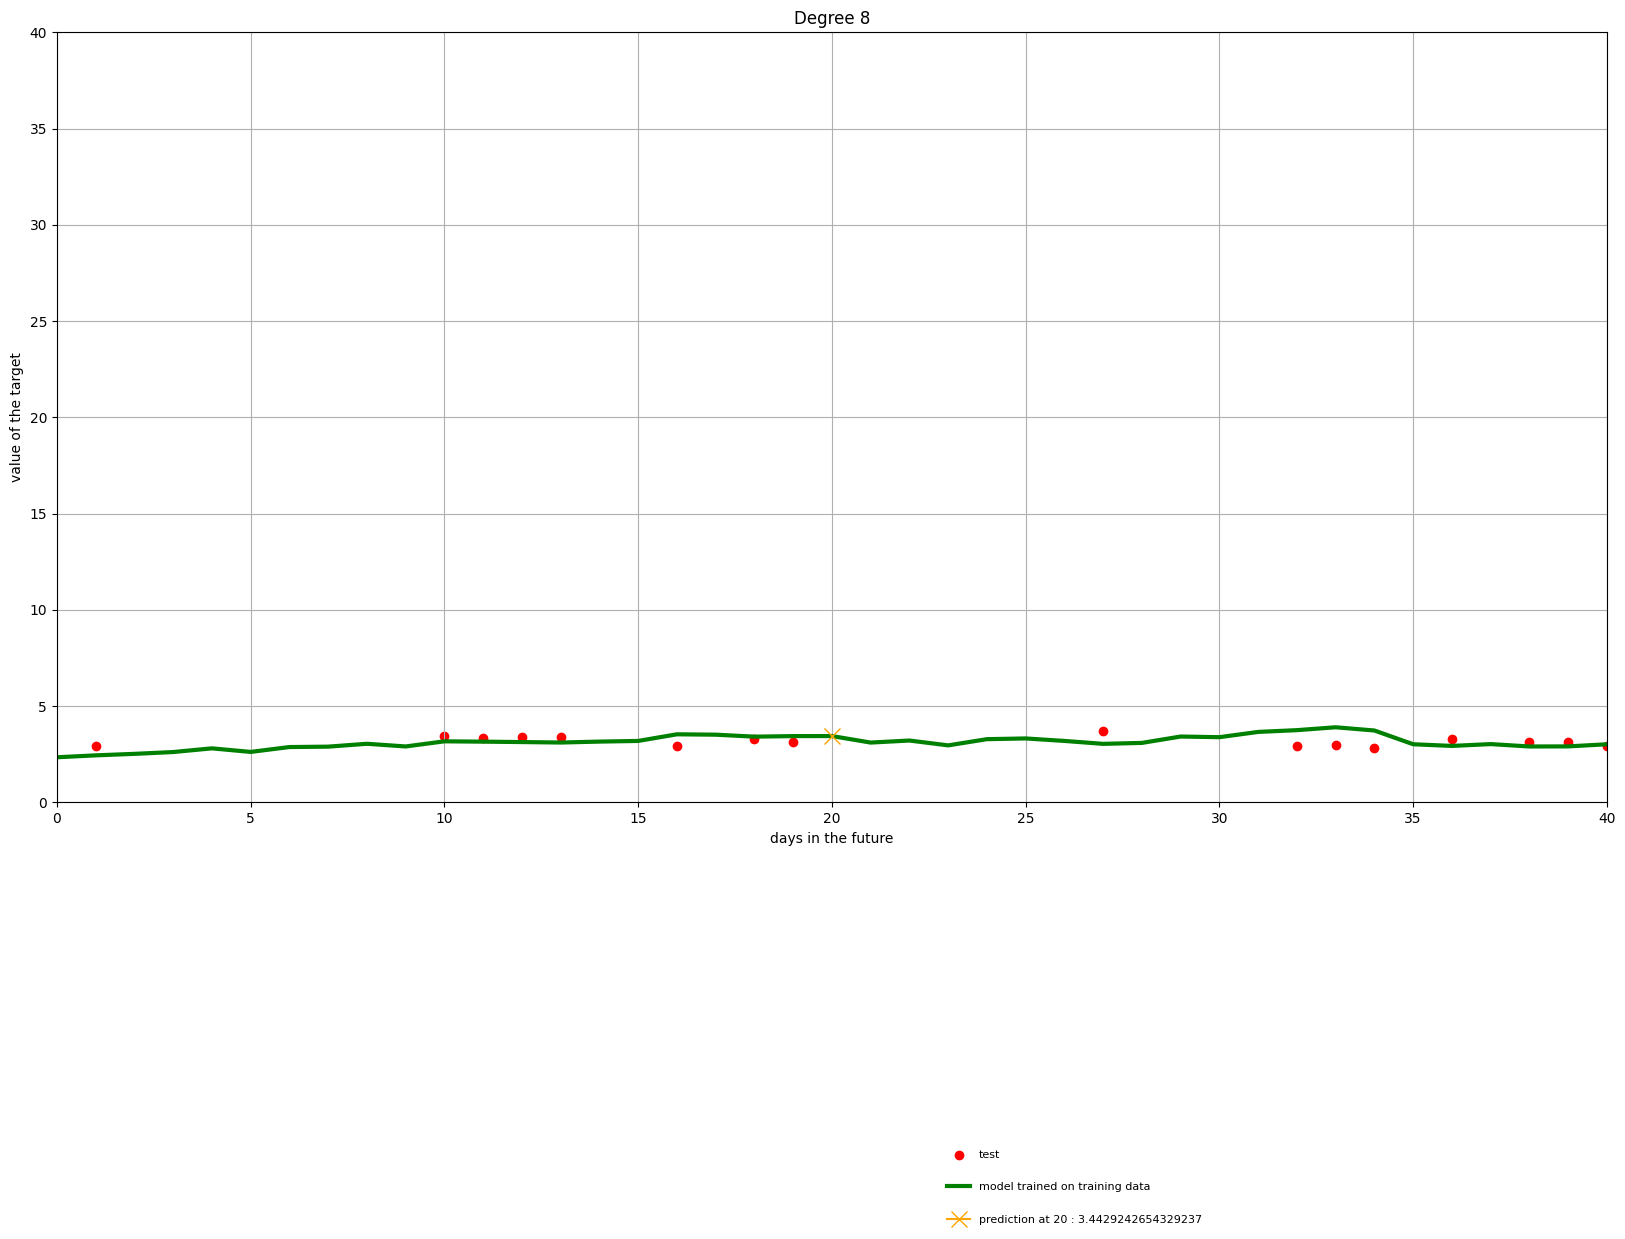

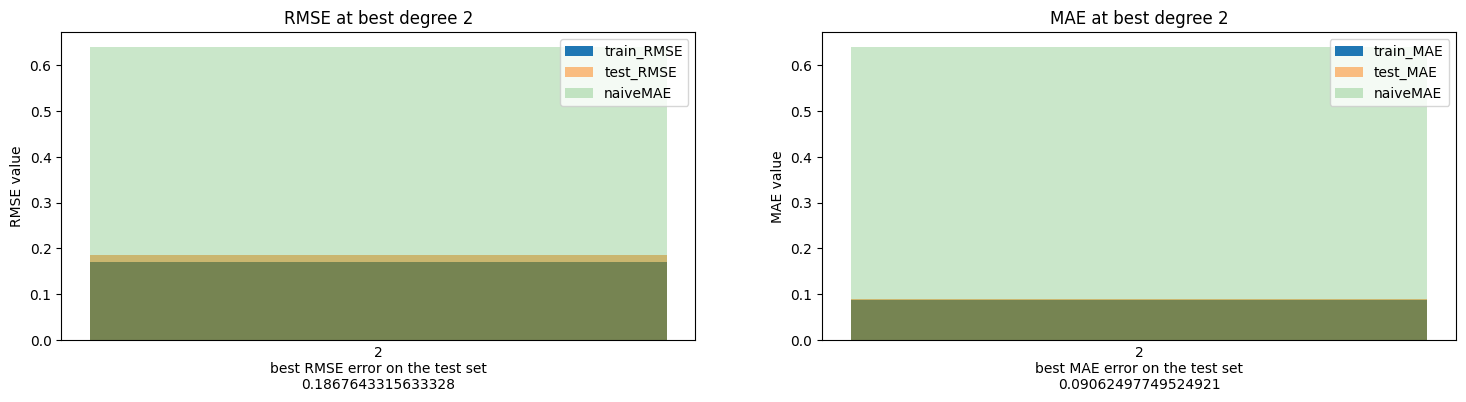

In [ ]:
# # ## number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
# # ##          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X0 = X[:, [0]]

def get_prediction_at_given_x(pipeln, feature_indecies, prediction_points, ax):
    preds = []
    for h in prediction_points:
        x_row = X[h, feature_indecies].reshape(1, -1)
        y_pred_at_this_point = pipeln.predict(x_row)[0]
        preds.append(y_pred_at_this_point)
        # print(y_pred_at_this_point)
        # print(X[h,0])
        # print(h)
        ax.plot(h, y_pred_at_this_point, marker='x', color='orange', label=f'prediction at {h} : {y_pred_at_this_point}', markersize=12)
    return preds

def predictionVals_Plot_DictOfErrors(prediction_points):
    train_and_test_errors_at_given_degree = {}
    polynomial_degrees = [1,2,3,4,5,6,7,8]
    feature_indecies = [0,1,2,3,4,5,6,7]
    plt.figure(figsize=(20,10))
    
    alphas_to_test = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
    for i in range(len(polynomial_degrees)):
        
        ### NOTE: make the line eq a mutlti-var lin eq
        polynomial_features_train = PolynomialFeatures(degree=polynomial_degrees[i], include_bias=False)
        
        ### NOTE: apply lin reg to the new mutlti-var lin eq
        linear_regression_model_train = RidgeCV(alphas=alphas_to_test)# ridge adds l2 to regression to shrink the coefficients of the loss funciton to prevent overfitting
        
        ### NOTE: instantiate the pipline
        pipeline_on_training_data = Pipeline([("polynomial_features", polynomial_features_train), ("linear_regression", linear_regression_model_train)])
        
        ### NOTE: apply the pipline
        
        ##spilt
        #                                                                                                                       
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X[:, feature_indecies], y, test_size=0.3, random_state=67, shuffle=True)

        ##fit 
        pipeline_on_training_data.fit(X_train2, y_train2)
        
        ##predict on train and test
        y_pred_train2 = pipeline_on_training_data.predict(X_train2)
        y_pred_test2 = pipeline_on_training_data.predict(X_test2)
        
        train_MAE2 = mean_absolute_error(y_train2, y_pred_train2)
        test_MAE2 = mean_absolute_error(y_test2, y_pred_test2)
        
        train_MSE2 = mean_squared_error(y_train2, y_pred_train2)
        test_MSE2 = mean_squared_error(y_test2, y_pred_test2)

        train_RMSE2 = np.sqrt(train_MSE2)
        test_RMSE2 = np.sqrt(test_MSE2)
        
        naive_MAE2 = mean_absolute_error(y_test2, np.full(y_test2.shape, np.mean(y_train2)))
        
        train_and_test_errors_at_given_degree[i] = {
            
            'train' : {
                'MAE' : train_MAE2,
                'MSE' : train_MSE2,
                'RMSE' : train_RMSE2
            },
            'test' : {
                'MAE' : test_MAE2,
                'MSE' : test_MSE2,
                'RMSE' : test_RMSE2
            },
            'naive_MAE' : naive_MAE2
        }
        
    def barchart_and_graph():
        rows = []
        for i, deg in enumerate(polynomial_degrees):
            m = train_and_test_errors_at_given_degree[i]
            rows.append({
                'deg' : deg,
                'train_RMSE' : m['train']['RMSE'],
                'test_RMSE' : m['test']['RMSE'],
                'train_MAE' : m['train']['MAE'],
                'test_MAE' : m['test']['MAE'],
                'naiveMAE' : m['naive_MAE']

            })
        # make a dataframe of the rows list using .sort_values by degree
        metrics_df = pd.DataFrame(rows).sort_values(['test_RMSE', 'test_MAE'], ascending=True)

        # print(metrics_df)
        # pick best degree (row) by the lowest test RMSE key then test MAE key then initialize the 
        best_row = metrics_df.sort_values(['test_RMSE', 'test_MAE'], ascending=True).iloc[0]  ## used AI to learn about the approach of the tie break (since RMSE punishes )
        # print(best_row)
        best_degree = int(best_row['deg'])
        # print(best_degree)
        
        poly_features_best = PolynomialFeatures(degree=best_degree, include_bias=False)
        linear_reg_best = RidgeCV(alphas=alphas_to_test)
        pipeline_best = Pipeline([("polynomial_features", poly_features_best), ("linear_regression", linear_reg_best)])
        
        # Re-split with same random_state to ensure consistency
        X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X[:, feature_indecies], y, test_size=0.3, random_state=67, shuffle=True)
        
        pipeline_best.fit(X_train_best, y_train_best)
    
        plt.figure(figsize=(20,10))
        
        ax = plt.subplot(1,1,1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.scatter(X_test2[:,0], y_test2, color="red", label='test')
        
        max_bound = prediction_points[0]
        max_bound = max_bound+20
    
        ax.set_xlim(0,max_bound)
        ax.set_ylim(0,max_bound)
        
        # LOBF_train_set = pipeline_on_training_data.predict(X[:, feature_indecies])
        LOBF_best = pipeline_best.predict(X[:, feature_indecies])
        
        # ax.plot(X0, LOBF_X, label="model trained on all data", color="purple", linewidth=2) data leakage 
        ax.plot(X0, LOBF_best, label="model trained on training data", color="green", linewidth=3)
        
        # prediction_vals = get_prediction_at_given_x(pipeline_on_training_data, feature_indecies, prediction_points, ax)
        prediction_vals = get_prediction_at_given_x(pipeline_best, feature_indecies, prediction_points, ax)
        
        ax.set_xlabel(f'days in the future')
        ax.set_ylabel('value of the target')
        ax.legend(loc='center left', bbox_to_anchor=(0.5, -0.5), ncol=1, fontsize=8, frameon=False, borderaxespad=10, labelspacing=2)
        ax.set_title(currency_we_want_to_look_at)
        ax.grid() 
        
        best_fit_plot = plt.gcf()
    # https://www.youtube.com/watch?v=G0Olm-4CP50
    # build a data frame of the collected errors 
        

        # plot bar charts t ocompare errors accross degrees 
        fig, axs = plt.subplots(1, 2, figsize=(18, 4))
            # - axs 0, 1, and 2 is the bar of the degree key for x and te train/test_error key for y, make sure to use aplpha to make it more transparent
        # axs[0].bar(metrics_df['deg'], metrics_df['train_RMSE'], label='train_RMSE', alpha=1)
        # axs[0].bar(metrics_df['deg'], metrics_df['test_RMSE'], label='test_RMSE', alpha=0.5)
        # axs[0].set_title('RMSE for each degree')
        # axs[0].set_xlabel('degree')
        # axs[0].set_ylabel('RMSE')
        # axs[0].legend()

        # axs[1].bar(metrics_df['deg'], metrics_df['train_MAE'], label='train_MAE', alpha=1)
        # axs[1].bar(metrics_df['deg'], metrics_df['test_MAE'], label='test_MAE', alpha=0.5)
        # axs[1].set_title('MAE for each degree')
        # axs[1].set_xlabel('degree')
        # axs[1].set_ylabel('MAE')
        # axs[1].legend()

        axs[0].bar(best_row['deg'], best_row['train_RMSE'], label='train_RMSE', alpha=1)
        axs[0].bar(best_row['deg'], best_row['test_RMSE'], label='test_RMSE', alpha=0.5)
        axs[0].bar(best_row['deg'], best_row['naiveMAE'], label='naiveMAE', alpha=0.25)
        axs[0].set_title(f'RMSE at best degree {best_degree}')
        axs[0].set_xlabel(f"{best_degree}\nbest RMSE error on the test set\n{best_row['test_RMSE']}")
        axs[0].set_xticks([])
        axs[0].set_ylabel('RMSE value')
        axs[0].legend()

        axs[1].bar(best_row['deg'], best_row['train_MAE'], label='train_MAE', alpha=1)
        axs[1].bar(best_row['deg'], best_row['test_MAE'], label='test_MAE', alpha=0.5)
        axs[1].bar(best_row['deg'], best_row['naiveMAE'], label='naiveMAE', alpha=0.25)
        axs[1].set_title(f'MAE at best degree {best_degree}')
        axs[1].set_xlabel(f"{best_degree}\nbest MAE error on the test set\n{best_row['test_MAE']}")
        axs[1].set_xticks([])
        axs[1].set_ylabel('MAE value')
        axs[1].legend()

        return best_fit_plot, axs[0], axs[1], prediction_vals
        
    best_graph, RMSE_bar_chart, MAE_bar_chart, prediction_vals = barchart_and_graph()
        
    return prediction_vals, train_and_test_errors_at_given_degree, best_graph, RMSE_bar_chart, MAE_bar_chart

pred_x_at_this_point = [20]

best_graph, train_and_test_errors_at_given_degree, prediction_vals, RMSE_bar_chart, MAE_bar_chart =  predictionVals_Plot_DictOfErrors(pred_x_at_this_point)

print(prediction_vals)
print(train_and_test_errors_at_given_degree)
print(best_graph)
print(RMSE_bar_chart)
print(MAE_bar_chart)
    

In [6]:
poly_deg = [1,2,3,4,5,6,7,8]
for i in range(len(poly_deg)):
    
    print(f"degree {i} train MAE : {train_and_test_errors_at_given_degree[i]['train']['MAE']}")
    print(f"degree {i} test MAE : {train_and_test_errors_at_given_degree[i]['test']['MAE']}")
    
    print(f"degree {i} train MSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
    print(f"degree {i} test MSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    
    print(f"degree {i} train RMSE : {train_and_test_errors_at_given_degree[i]['train']['MSE']}")
    print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['test']['MSE']}")
    print(f"degree {i} test RMSE : {train_and_test_errors_at_given_degree[i]['naive_MAE']}")

degree 0 train MAE : 0.08395077836505026
degree 0 test MAE : 0.08620814998643603
degree 0 train MSE : 0.03216879557560645
degree 0 test MSE : 0.03958591301996747
degree 0 train RMSE : 0.03216879557560645
degree 0 test RMSE : 0.03958591301996747
degree 0 test RMSE : 0.6405055236523227
degree 1 train MAE : 0.08720755801962043
degree 1 test MAE : 0.09062497749524921
degree 1 train MSE : 0.029297977967326132
degree 1 test MSE : 0.034880915544298514
degree 1 train RMSE : 0.029297977967326132
degree 1 test RMSE : 0.034880915544298514
degree 1 test RMSE : 0.6405055236523227
degree 2 train MAE : 131.70513212799548
degree 2 test MAE : 132.82276827157204
degree 2 train MSE : 25231.918543713466
degree 2 test MSE : 24289.762363665242
degree 2 train RMSE : 25231.918543713466
degree 2 test RMSE : 24289.762363665242
degree 2 test RMSE : 0.6405055236523227
degree 3 train MAE : 88509406.26037538
degree 3 test MAE : 88460680.10922468
degree 3 train MSE : 1.2294163365275654e+16
degree 3 test MSE : 1.1523

### show MAE, MSE, and RMSE and explain what this means for the predictions of the selected feature

#### * high train error, high test error --> underfitting
#### * low train error, high test error --> overfitting
#### * low train error, low test error --> well fitted

*RMSE*: 
- it penalizes the large errors more, it highlights models with fewer big mistakes
- we square all the errors to make them non-negative and to penalize larger mistakes disproprtionately 
	- big misses weigh more than small ones 	

*MSE*: 

# Selecting the best degree by lowest RMSE (if there is a tie between one or more rows then we will switch to the MAE)

### the order of selection in the tie-break selection process is RMSE, MAE 
### - RMSE to punish outliers (aka bigger mistakes/larger residuals)
### - MAE as a secondary because absolute error is usful for punishing more smaller residulas and less sensitive to outliers

## I am going to ask a TA about how to get the graph of the best degree here alonside with the prediction value that can be returned to the front end and have that prediction value plotted as a point on the graph

$$\mathbf{v}^\top \hat{\mathbf{u}} =

# FINAL THINGS THAT NEED TO BE PUSHED TO THE FRONT END
## 1) the best fit graph
## 2) the 'RMSE at best degree' and 'MAE at best degree' bar charts
## 3) the predicted value (accompanied by the name of the currency preferably)